# Train example notebook

This notebook is used to implement the training of a neural network for classification of `Cloud`, `Edge`, `Good` images. <br> It is advisable to use this notebook to get practice and debug your code. To speed up the execution, once you are ready, you should move to a scripted version.

## 1. - Imports

Select `CUDA_VISIBLE_DEVICES` to the `Graphics Proceesing Unit (GPU)` index that you want to use to enable the use of GPU.

In [1]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0" # GPU index

Enabling autoreload of different packages.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch 
import sys
sys.path.insert(1, os.path.join("..", "data"))
sys.path.insert(1, os.path.join("..", "utils"))
from torchvision import datasets, transforms
from plot_utils import plot_image
from torch.utils.data import DataLoader
from torch.utils.data import random_split

## 2. - Datasets

### 2.1 - Creating datasets

Now we read the images from the target directory `path_data`. Set `path_data` to the directory containing the `Cloud`, `Edge`, `Good` subfolders.  Moreover, it will automatically split the total dataset into the train, cross validation and test splits by using a pseudo-random splitting algorithm. You can reproduce the split by specifying the variable `seed`. **NB**:
- The train split contains 70% of the whole images.
- The valid splits contains 15% of the whole images.
- The test splits contains 15% of the whole images.<br>**YOU MUST NOT CHANGE THE TEST SPLIT SIZE!!!**

In [4]:
# Path to the data folder (update the variable to your path).
path_data=os.path.join("..", "data")
# Seed value
seed=22
torch.manual_seed(seed)

from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import v2

import numpy as np

image_width = 1024
image_height = 1942
scale_factor = 0.1

valid_size = 0.15
test_size = 0.15

dataset_mean = [0.2391, 0.4028, 0.4096]
dataset_std = [0.2312, 0.3223, 0.3203]

transform = transforms.Compose([v2.ToImage(),
                                v2.Resize((int(256), int(256))),
                                v2.RandomHorizontalFlip(p=0.5),
                                v2.RandomVerticalFlip(p=0.5),
                                v2.ToDtype(torch.float32, scale=True),
                                v2.Grayscale(num_output_channels=1),
                                v2.Normalize((dataset_mean),(dataset_std))
                                ])

dataset = datasets.ImageFolder(root=path_data, 
                                 transform=transform)

n_val = int(np.floor(valid_size * len(dataset)))
n_test = int(np.floor(test_size * len(dataset)))
n_train = len(dataset) - n_val - n_test

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

**Hint:** before proceeding, make sure that your `Edge`,`Cloud`, and `Good` samples are well enough among the `train`, `valid`,`test` splits. To print datasets statistics, run the next line.  Remember that the number of images in the different splits is distributed as described above. <br> If you are not happy with the data distribution, you can update the seed used and create a new dataset by rerunning the cell above. 

### 2.2. - Create data loaders.

The next lines will create a dataloader. A data loader is used to break the dataset into batches of a size `batch_size`. <br> This is useful to ensure that your dataset will fit into your memory and to create a "stochastic" implementation of gradient descent. <br> For more information, please, check: [data loader](https://www.educative.io/answers/what-is-pytorch-dataloader).<br>
Specify `batch_size` (**Hint**: use powers of 2. Typical values are between 8 and 64).

In [5]:
batch_size=32
# Train loader
train_loader = DataLoader(train_ds, batch_size=batch_size, pin_memory=False, shuffle=True)
# Cross validation data loader
valid_loader = DataLoader(val_ds, batch_size=batch_size, pin_memory=False, shuffle=True)
# Test data loader
test_loader = DataLoader(test_ds, batch_size=batch_size, pin_memory=False, shuffle=True)

#0 - cloud
#1 - edge
#2 - good

unique, counts = np.unique(torch.tensor([train_ds.dataset.targets[i] for i in train_ds.indices]), return_counts=True)
print("Train split: ", dict(zip(unique, counts)))

unique, counts = np.unique(torch.tensor([test_ds.dataset.targets[i] for i in test_ds.indices]), return_counts=True)
print("Test split: ", dict(zip(unique, counts)))

unique, counts = np.unique(torch.tensor([val_ds.dataset.targets[i] for i in val_ds.indices]), return_counts=True)
print("Validation split: ", dict(zip(unique, counts)))

Train split:  {0: 61, 1: 73, 2: 80}
Test split:  {0: 13, 1: 12, 2: 20}
Validation split:  {0: 16, 1: 12, 2: 17}


## 3 - Training

Now, it is your turn! Add your code below to load a Neural Network model, select optimizers, learning rate and perform training. <br>
Good luck!

...

Using cache found in C:\Users\20181212/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\20181212\AppData\Local\anaconda3\envs\OMICRON\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\20181212\AppData\Local\anaconda3\envs\OMICRON\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


using GPU to train model


C:\Users\20181212\AppData\Local\anaconda3\envs\OMICRON\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 1, Training Loss: 8.68, Validation Loss: 8.62, accuracy = 0.00
Epoch: 2, Training Loss: 8.50, Validation Loss: 8.16, accuracy = 0.02
Epoch: 3, Training Loss: 8.17, Validation Loss: 7.89, accuracy = 0.02
Epoch: 4, Training Loss: 7.74, Validation Loss: 8.14, accuracy = 0.02
Epoch: 5, Training Loss: 7.59, Validation Loss: 7.69, accuracy = 0.00
Epoch: 6, Training Loss: 7.29, Validation Loss: 7.71, accuracy = 0.04
Epoch: 7, Training Loss: 7.07, Validation Loss: 7.26, accuracy = 0.07
Epoch: 8, Training Loss: 6.98, Validation Loss: 6.94, accuracy = 0.07
Epoch: 9, Training Loss: 6.51, Validation Loss: 7.17, accuracy = 0.04
Epoch: 10, Training Loss: 6.45, Validation Loss: 6.68, accuracy = 0.11
Epoch: 11, Training Loss: 6.26, Validation Loss: 6.49, accuracy = 0.09
Epoch: 12, Training Loss: 6.10, Validation Loss: 6.48, accuracy = 0.09
Epoch: 13, Training Loss: 5.90, Validation Loss: 6.13, accuracy = 0.13
Epoch: 14, Training Loss: 5.71, Validation Loss: 6.09, accuracy = 0.09
Epoch: 15, Trai

KeyboardInterrupt: 

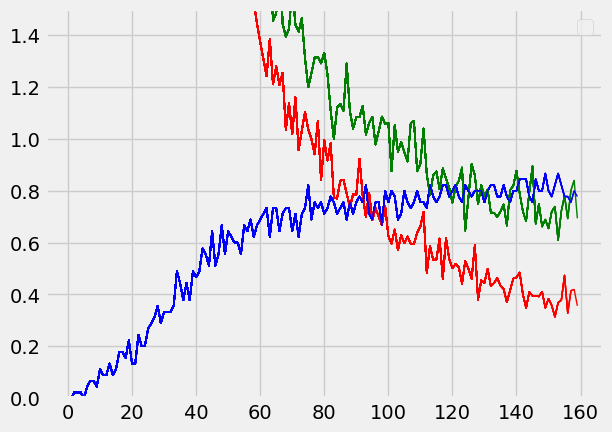

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile
from datetime import datetime
import matplotlib.pyplot as plt

    
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18',pretrained=True)
    
import torch.optim as optim
optimizer = torch.optim.SGD(model.parameters(), lr=0.00005)

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=100, device="cpu"):
    
    plotting = True

    if plotting == True:
       
        # make filename to store figure
        timestr = datetime.now().strftime("%Y%m%d-%H%M%S")
        filename = './result_plots/training_plot_' + timestr + '.png'

        # intialize plot
        plt.ion()
        plt.style.use('fivethirtyeight')
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.legend([' (red)Training Loss', '(green)Validation Loss', '(blue)Accuracy'])
        ax.set_ylim([0, 1.5])

        # x - axis :array with epochs
        epoch_arr = np.arange(1, epochs+1)

        # y-axis: storing intermediate results for plotting 
        cum_train_loss = []
        cum_val_loss = []
        acc = [] 


        
    # loop over epochs
    for epoch in range(1, epochs+1):

        # training loop
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
            
        training_loss /= len(train_loader.dataset)

        # validation loop
        model.eval()
        num_correct = 0 
        num_examples = 0
        
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]

        valid_loss /= len(val_loader.dataset)
        
        
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))


        if plotting == True:
            
            # storing intermediate results for plotting
            cum_train_loss.append(training_loss)
            cum_val_loss.append(valid_loss)
            acc.append(num_correct / num_examples)

            # plotting results 
            ax.plot(epoch_arr[:epoch], cum_train_loss, 'r',linewidth=1)
            ax.plot(epoch_arr[:epoch], cum_val_loss, 'g',linewidth=1)
            ax.plot(epoch_arr[:epoch], acc, 'b',linewidth=1)

            # refresh figure
            fig.canvas.draw()
            fig.canvas.flush_events()

            # saving intermediate plots
            if epoch % 10 == 0:
                fig.savefig(filename)


    # saving final plot 
    fig.savefig()

    return fig


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("using GPU to train model")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")
    print("using CPU to train model")


model.to(device)

train(model, optimizer, torch.nn.CrossEntropyLoss(),train_loader, valid_loader, epochs=500, device=device)

In [7]:
def test(model, test_loader, loss_fn, num_runs=5, device="cpu"):
    model.eval()
    total_accuracy = 0.0
    total_loss = 0.0

    for run in range(num_runs):
        num_correct = 0
        num_examples = 0

        for batch in test_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            with torch.no_grad():
                output = model(inputs)
                loss = loss_fn(output, targets)
                total_loss += loss.item() * inputs.size(0)

            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]

        accuracy = num_correct / num_examples
        total_accuracy += accuracy

    average_loss = total_loss / (num_runs * len(test_loader.dataset))
    average_accuracy = total_accuracy / num_runs

    print('Average Test Loss: {:.2f}, Average Test Accuracy: {:.2f}'.format(average_loss, average_accuracy))

num_runs = 10
test(model, test_loader, torch.nn.CrossEntropyLoss(), num_runs=num_runs, device=device)

Average Test Loss: 0.58, Average Test Accuracy: 0.81
